# Machine Learning Forecasting in Time Series

This is an example of time series forecasting using machine learning techniques. I perform the following steps to achieve a prediction:
- Feature Engineering
- Train/Test Split
- Model cross-validation
- Generate prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
# Plotting functions
def plot_lineplot_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.lineplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

def plot_scatter_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

# 0. Load Source Data
## 0.1 Air Passangers Dataset

In [3]:
AirPassengers = pd.read_csv("./datasets/AirPassengers.csv")
AirPassengers['Month'] = pd.to_datetime(AirPassengers['Month'])
AirPassengers = AirPassengers.rename({"Month": "DateTime"}, axis=1)
AirPassengers.head()

(144, 2)


,DateTime,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


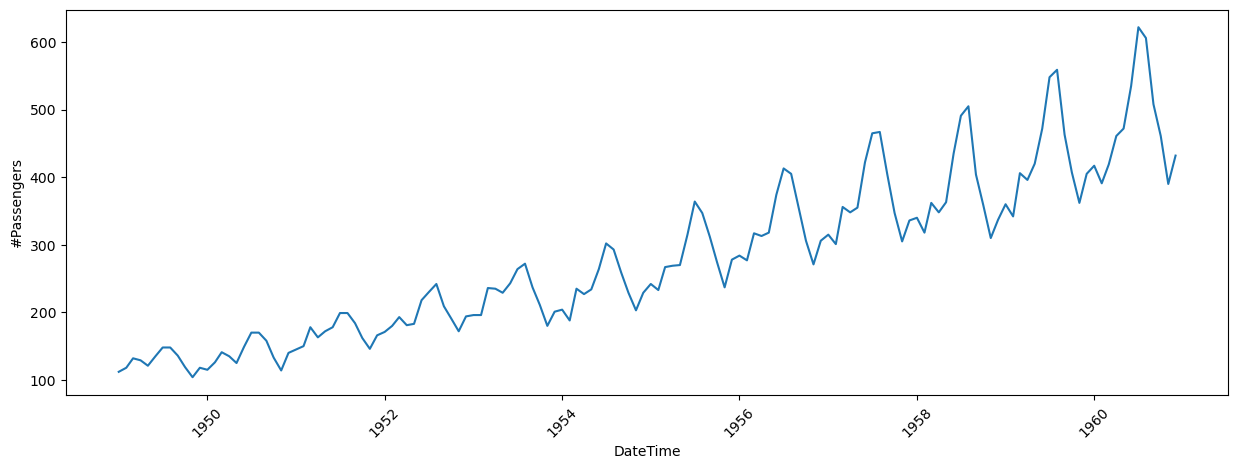

In [4]:
plot_lineplot_time_series(AirPassengers, "DateTime", "#Passengers")

# 1. Feature Engineering

To apply time series to a machine learning algorithm, I first need to convert it into features that can be passed to the model. 4 strategies will be used here:
- Datetime features
- Lag features
- Rolling window features
- Expanding window features

## 1.1. Datetime features

Extract features from the month and year. No day or time is provided in this dataset.

In [5]:
AirPassengers['Year']=AirPassengers['DateTime'].dt.year 
AirPassengers['Month']=AirPassengers['DateTime'].dt.month
AirPassengers.head()

,DateTime,#Passengers,Year,Month
0,1949-01-01,112,1949,1
1,1949-02-01,118,1949,2
2,1949-03-01,132,1949,3
3,1949-04-01,129,1949,4
4,1949-05-01,121,1949,5


## 1.2. Lag Features

Extract features from previous timestamps. In this case, I extract the 12 previous values, generating 12 additional features.

In [6]:
for i in range(12):
    lag = i+1
    AirPassengers['Lag_' + str(lag)] = AirPassengers['#Passengers'].shift(lag)

AirPassengers.head(20)

,DateTime,#Passengers,Year,Month,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12
0,1949-01-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-01,118,1949,2,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-01,132,1949,3,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04-01,129,1949,4,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05-01,121,1949,5,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1949-06-01,135,1949,6,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1949-07-01,148,1949,7,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1949-08-01,148,1949,8,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN
8,1949-09-01,136,1949,9,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN
9,1949-10-01,119,1949,10,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN


## 1.3. Rolling window features

In this case, I extract statistical features using a window over the last 12 months. For this example, I obtain the average and the std dev, but multiple other methods can be used.

In [7]:
AirPassengers["rw_mean"] = AirPassengers['#Passengers'].rolling(12).mean()
AirPassengers["rw_stddev"] = AirPassengers['#Passengers'].rolling(12).std()
AirPassengers.head(20)

,DateTime,#Passengers,Year,Month,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,rw_mean,rw_stddev
0,1949-01-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-01,118,1949,2,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-01,132,1949,3,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04-01,129,1949,4,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05-01,121,1949,5,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1949-06-01,135,1949,6,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1949-07-01,148,1949,7,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1949-08-01,148,1949,8,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1949-09-01,136,1949,9,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN
9,1949-10-01,119,1949,10,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN


## 1.4. Expanding window features

Same as before, but taking into account all past values.

In [8]:
AirPassengers["ew_mean"] = AirPassengers['#Passengers'].expanding(12).mean()
AirPassengers["ew_stddev"] = AirPassengers['#Passengers'].expanding(12).std()
AirPassengers.head(20)

,DateTime,#Passengers,Year,Month,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,rw_mean,rw_stddev,ew_mean,ew_stddev
0,1949-01-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-01,118,1949,2,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-01,132,1949,3,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04-01,129,1949,4,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05-01,121,1949,5,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1949-06-01,135,1949,6,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1949-07-01,148,1949,7,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1949-08-01,148,1949,8,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1949-09-01,136,1949,9,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1949-10-01,119,1949,10,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
AirPassengers = AirPassengers.dropna()
AirPassengers.head()

,DateTime,#Passengers,Year,Month,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,rw_mean,rw_stddev,ew_mean,ew_stddev
12,1950-01-01,115,1950,1,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,126.916667,13.453342,125.769231,13.528697
13,1950-02-01,126,1950,2,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,127.583333,13.166475,125.785714,12.998098
14,1950-03-01,141,1950,3,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,128.333333,13.686977,126.800000,13.126854
15,1950-04-01,135,1950,4,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,128.833333,13.822467,127.312500,12.846368
16,1950-05-01,125,1950,5,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.166667,13.663710,127.176471,12.451081


# 2. Train/Test split

Time series can't be splitted randomly as in a standard Machine Learning algorithm, as the order of the records is important. Hence, I take the last few samples as the testset.

In [10]:
idx_train_test_split = round(AirPassengers.shape[0] * 0.8)
train_set = AirPassengers.iloc[:idx_train_test_split]
test_set = AirPassengers.iloc[idx_train_test_split:]

print(f"Train set rows: {train_set.shape[0]}")
print(f"Test set rows: {test_set.shape[0]}")

Train set rows: 106
Test set rows: 26


## 3. Model cross-validation

As discussed before, splitting the dataset is tricky due to the order. For this purpose, I will use the TimeSeriesSplit object.

In [11]:
# Divide features and target
X = train_set.drop(["DateTime", "#Passengers"], axis=1).reset_index().values
y = train_set["#Passengers"].values

In [12]:
def run_model_and_evaluate(model, X, y):

    rmse = []

    tscv = TimeSeriesSplit(n_splits=2, test_size=10)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):

        # Load CV features
        X_train = X[train_index] 
        y_train = y[train_index]

        # Train the model
        model.fit(X_train, y_train)

        # Obtain prediction dataset
        X_test, y_test = X[test_index], y[test_index]

        # Predict both models
        model_pred = model.predict(X_test)

        # Calculate RMSE
        rmse.append(np.sqrt(mean_squared_error(y_test, model_pred)))

    return rmse

In [19]:
models = [
    LogisticRegression(), 
    DecisionTreeRegressor(), 
    RandomForestRegressor(n_estimators=1000, max_depth = 5), 
    # XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
]

for model in models:
    rmse_list = run_model_and_evaluate(model, X, y)
    print("***************************")
    print(model)
    print(rmse_list)
    print("***************************")

/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

***************************
LogisticRegression()
[49.137562007083744, 21.723259423944647]
***************************
***************************
DecisionTreeRegressor()
[28.679260799399973, 41.54996991575325]
***************************
***************************
RandomForestRegressor(max_depth=5, n_estimators=1000)
[39.348900893277374, 51.365729305106264]
***************************


## 4. Generate output

Looks like a simple logistic regression would do. 

/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


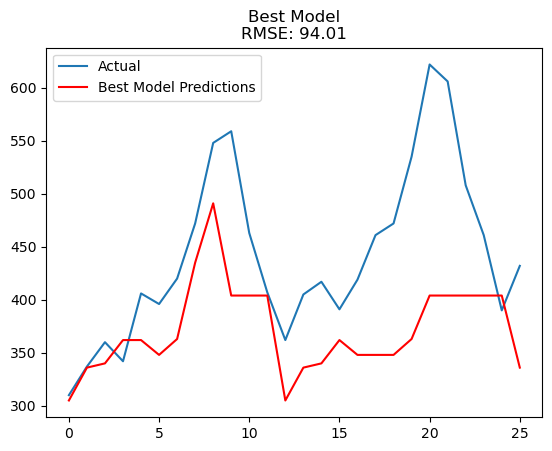

In [25]:
# Select target model
target_model = LogisticRegression()

# Divide features and target - Train
X_train = train_set.drop(["DateTime", "#Passengers"], axis=1).reset_index().values
y_train = train_set["#Passengers"].values

# Divide features and target - Test
X_test = test_set.drop(["DateTime", "#Passengers"], axis=1).reset_index().values
y_test = test_set["#Passengers"].values

# Train the model
target_model.fit(X_train, y_train)

# Predict both models
model_pred = target_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))

# Visualize ARIMA model performance
plt.plot(y_test, label="Actual")
plt.plot(model_pred, color="red", label="Best Model Predictions")
plt.legend()
plt.title(f"Best Model\nRMSE: {rmse:.2f}")
plt.show()

This result indicates that the trend was not captured by the model. Further feature engineering or signal preprocessing might help.